In [2]:
import numpy as np
import xml.etree.ElementTree as ET
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn
import os
from gensim import corpora
import seaborn as sns


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
import pandas

from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\waii\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Read Data ##

In [3]:
dir_leng = len(os.listdir('./category'))
category_dict = {}
i = 0
for file in os.listdir('./category'):
    i += 1
    print(str((i/dir_leng)*100),end="\r")
#     print(file,len(file))
    pmid_set = set()
    read_file = open('./category/'+file).read().splitlines()
    for r in read_file:
        pmid_set.add(r.strip())
    category_dict[file[:len(file)-13]] = list(pmid_set)
  

In [4]:
def generate_category_lookup():
        state = ""
        category_tree = {}
        tool_file = open("./webcrawler/omictool_toollist.txt","r")
        for t in tool_file:
                t_list = t.strip().split()
                if t_list[-3] not in category_tree:
                    if len(t_list) > 5:
                        category_tree[t_list[-3]] = t_list[-5] 
                    else:
                        category_tree[t_list[-3]] = None
                        
                    
        return category_tree

In [26]:
pos_abstract = []
i = 0
dir_leng = len(os.listdir('./src/train/find_pmid_with_abstract'))
print(dir_leng)
# cat = set()

for file in os.listdir('./src/train/find_pmid_with_abstract'):
    i += 1
    print(str((i/dir_leng)*100),end="\r")
    et = ET.parse('./src/train/find_pmid_with_abstract/'+file)
    root = et.getroot()
    article = root.find('MedlineCitation').find('Article').findall('Abstract')
    pmid = root.find('MedlineCitation').findall('PMID')
# #     print(pmid)
#     if len(pmid) > 1:
#         print(pmid)
    for category,p_list in category_dict.items():
#         print(category)
        for p in pmid:
            if p.text in p_list:
#                 print(p.text)
#                 cat.add(category)
                word = {}
                for a in article:
                    atext = a.find('AbstractText').text
#                     print(atext)
                    if type(atext) == str:
#                         print(atext)
                        pos_abstract.append([atext,category])

22121


In [27]:
pos_title = []
i = 0
dir_leng = len(os.listdir('./src/train/find_pmid_with_abstract'))
print(dir_leng)
cat = set()

for file in os.listdir('./src/train/find_pmid_with_abstract'):
    i += 1
    print(str((i/dir_leng)*100),end="\r")
    et = ET.parse('./src/train/find_pmid_with_abstract/'+file)
    root = et.getroot()
    title = root.find('MedlineCitation').find('Article').findall('ArticleTitle')
    pmid = root.find('MedlineCitation').findall('PMID')
#     print(pmid)
#     if len(pmid) > 1:
#         print(pmid)
    for category,p_list in category_dict.items():
#         print(category)
        for p in pmid:
            if p.text in p_list:
#                 print(p.text)
                cat.add(category)
                word = {}
                for a in title:
                    atext = a.text
#                     print(atext)
                    if type(atext) == str:
#                         print(atext)
                        pos_title.append([atext,category])

22121


In [28]:
category_file = open('category_pmid_count_minimal.txt','r').readlines()

## Find Top 20 category ##

In [29]:
top20_category = {}
for cat in category_file:
    split_str = cat.split('\t')
    top20_category[split_str[0]] = int(split_str[1].strip('\n'))
top20_category = sorted(top20_category.items(),key=lambda kv: kv[1],reverse=True)[0:20]
top20_category_first = [t[0] for t in top20_category]

In [30]:
c = 0 
for v in top20_category:
    c += v[1]
print(c)

16965


In [31]:
pos_without_category = []
p_category = []
for p in pos_abstract:
    if str(p[1]+'-category') in top20_category_first:
        pos_without_category.append(p[0])
        p_category.append(p[1])

In [32]:
for i in set(p_category):
    print(i)

gene-expression-analysis
drug-discovery
protein-structure-analysis
rna-transcription-databases
rna-seq
phylogenetics-and-phylogenomics
population-genomics
dna-sequence-databases
protein-sequence-analysis
protein-interaction-databases
protein-sequence-databases
non-coding-rna-databases
genome-annotation2
ms-based-untargeted-proteomics
metagenomics
rna-structure-analysis
whole-genome-resequencing
non-coding-rna-analysis
protein-interaction-analysis
chemoinformatics-databases


In [33]:
pos_title_without_category = []
tp_category = []
for p in pos_title:
    if str(p[1]+'-category') in top20_category_first:
        pos_title_without_category.append(p[0])
        tp_category.append(p[1])

In [34]:
stemmer = PorterStemmer()
lemma = nltk.stem.WordNetLemmatizer()
def lemmatize_stemming(text):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    return lemma.lemmatize(text)

def preprocess(text):
    result = []
#     remove_list = [':']
    for token in simple_preprocess(text):
        if token not in STOPWORDS and token not in remove_list:
            result.append(lemmatize_stemming(token))
    return result

## Vectorize ##

In [35]:
countvec = CountVectorizer(stop_words='english')
countvec.fit(pos_without_category)
stop = countvec.get_feature_names()
stop = [i for i in stop if i.isdigit()]
stop_words = text.ENGLISH_STOP_WORDS.union(stop)

In [36]:
t_countvec = CountVectorizer(stop_words='english')
t_countvec.fit(pos_title_without_category)
t_stop = t_countvec.get_feature_names()
t_stop = [i for i in stop if i.isdigit()]
t_stop_words = text.ENGLISH_STOP_WORDS.union(t_stop)

In [37]:
cutoff = int(len(pos_without_category)*(4/5))

print(cutoff,len(pos_without_category))

print('train on '+str(cutoff)+' docs, test on '+str(len(pos_without_category)-cutoff)+ ' docs')


12534 15668
train on 12534 docs, test on 3134 docs


In [38]:
t_cutoff = int(len(pos_title_without_category)*(4/5))

print(t_cutoff,len(pos_title_without_category))

print('train on '+str(t_cutoff)+' docs, test on '+str(len(pos_title_without_category)-t_cutoff)+ ' docs')


12542 15678
train on 12542 docs, test on 3136 docs


In [39]:
vectorizer = TfidfVectorizer(min_df=122,stop_words=set(stop_words))
vectorizer.fit(pos_without_category[:cutoff])
x_train = vectorizer.transform(pos_without_category[:cutoff])
x_test = vectorizer.transform(pos_without_category[cutoff:])

In [40]:
feature_names = np.array(vectorizer.get_feature_names())
sorted_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf :\n{}".format(feature_names[sorted_idf[:3]]))
print("Features with highest idf :\n{}".format(feature_names[sorted_idf[-3:]]))

Features with lowest idf :
['data' 'based' 'http']
Features with highest idf :
['contact' 'expert' 'partial']


In [41]:
title_vectorizer = TfidfVectorizer(min_df=26,stop_words=set(t_stop_words))
title_vectorizer.fit(pos_title_without_category[:t_cutoff])
x_title_train = title_vectorizer.transform(pos_title_without_category[:t_cutoff])
x_title_test = title_vectorizer.transform(pos_title_without_category[t_cutoff:])

In [42]:
feature_names = np.array(title_vectorizer.get_feature_names())
sorted_idf = np.argsort(title_vectorizer.idf_)
print("Features with lowest idf :\n{}".format(feature_names[sorted_idf[:3]]))
print("Features with highest idf :\n{}".format(feature_names[sorted_idf[-3:]]))

Features with lowest idf :
['database' 'protein' 'data']
Features with highest idf :
['circular' 'files' 'ion']


In [43]:
print(len(vectorizer.get_feature_names()),len(title_vectorizer.get_feature_names()))

1387 627


In [44]:
clf = MultinomialNB()
clf.fit(x_train, p_category[:cutoff])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
clf.score(x_test,p_category[cutoff:])

0.574345883854499

In [46]:
f1_score(clf.predict(x_test),p_category[cutoff:],average='micro')

0.574345883854499

In [47]:
f1_score(clf.predict(x_test),p_category[cutoff:],average='macro')

0.5245105564248328

In [48]:
clf_t = MultinomialNB()
clf_t.fit(x_title_train, tp_category[:t_cutoff])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [49]:
print(clf_t.score(x_title_test,tp_category[t_cutoff:]))

0.5082908163265306


In [50]:
f1_score(clf_t.predict(x_title_test),tp_category[t_cutoff:],average='micro')

0.5082908163265306

In [51]:
f1_score(clf_t.predict(x_title_test),tp_category[t_cutoff:],average='macro')

0.4525743723256127

## Overlap ##

In [52]:
overlap = pandas.read_csv('overlap.csv')
overlap_list = []
for c in overlap.columns[1:]:
    for r in range(len(overlap[overlap.columns[0]])):
        if overlap[c][r] > 0:
            overlap_list.append([c,overlap[overlap.columns[0]][r],overlap[c][r]])
            
# overlap_list
# overlap['super-resolution-imaging-category']

In [53]:
overlap_dict = {}
for v in overlap_list:
    if v[0] not in overlap_dict:
        overlap_dict[v[0]] = []
    overlap_dict[v[0]].append(v[1])

In [54]:
for v in overlap_list:
    print(v[0],v[1],v[2])

small-rna-seq-category rna-structure-analysis-category 1
synthetic-biology-category rna-structure-analysis-category 1
synthetic-biology-category small-rna-seq-category 1
synthetic-biology-databases-category synthetic-biology-category 2
functional-magnetic-resonance-imaging-category biomedical-magnetic-resonance-imaging-category 2
conventional-fluorescence-microscopy-category laser-scanning-microscopy-category 1
chip-seq-category dnase-seq-category 2
chip-seq-category protein-interaction-analysis-category 1
chip-seq-category ontology-generation-category 1
protein-structure-databases-category protein-sequence-analysis-category 1
macroscopy-image-data-category laser-scanning-microscopy-category 1
macroscopy-image-data-category microscopy-image-data-category 1
macroscopy-image-data-category conventional-fluorescence-microscopy-category 1
chemoinformatics-databases-category protein-interaction-analysis-category 1
protein-interaction-databases-category protein-sequence-analysis-category 1
pr

In [55]:
count_category = {}
for cat in category_file:
    split_str = cat.split('\t')
    count_category[split_str[0]] = int(split_str[1].strip('\n'))
count_category_first = [t[0] for t in top20_category]

In [56]:
tranforms_dict = {}
thres = 0.001
for v in overlap_list:
    if v[2]/count_category[v[0]] >= thres:
        if count_category[v[0]] > count_category[v[1]]:
            if v[1] not in tranforms_dict:
                tranforms_dict[v[1]] = [v[0],count_category[v[0]]]
            else:
                if count_category[v[0]] > tranforms_dict[v[1]][1]:
                    tranforms_dict[v[1]] = [v[0],count_category[v[0]]]
        if count_category[v[1]] > count_category[v[0]]:
            if v[0] not in tranforms_dict:
                tranforms_dict[v[0]] = [v[1],count_category[v[1]]]
            else:
                if count_category[v[1]] > tranforms_dict[v[0]][1]:
                    tranforms_dict[v[0]] = [v[1],count_category[v[1]]]                

In [57]:
pos_abstract = []
i = 0
dir_leng = len(os.listdir('./src/train/find_pmid_with_abstract'))
print(dir_leng)
# cat = set()
# pmid_duplicate = []
for file in os.listdir('./src/train/find_pmid_with_abstract'):
    i += 1
    print(str((i/dir_leng)*100),end="\r")
    et = ET.parse('./src/train/find_pmid_with_abstract/'+file)
    root = et.getroot()
    article = root.find('MedlineCitation').find('Article').findall('Abstract')
    title = root.find('MedlineCitation').find('Article').find('ArticleTitle')
    pmid = root.find('MedlineCitation').findall('PMID')
# #     print(pmid)
#     if len(pmid) > 1:
#         print(pmid)
    for category,p_list in category_dict.items():
#         print(category)
        
#         if category in tranforms_dict:
#             print(category)
        for p in pmid:
#             if p.text not in pmid_duplicate:
                if p.text in p_list:
    #                 print(p.text)
    #                 cat.add(category)
                    word = {}
                    for a in article:
                        atext = a.find('AbstractText').text
    #                     print(atext)
                        if type(atext) == str:
    #                         print(atext)
                            if category+'-category' in tranforms_dict:
    #                             if tranforms_dict[category+'-category'][0][:len(tranforms_dict[category+'-category'][0])-9] == 'whole-genome-resequencing':
    #                                 print(tranforms_dict[category+'-category'][0][:len(tranforms_dict[category+'-category'][0])-9])
                                tran = tranforms_dict[category+'-category'][0]
#                                 if tran[:-9] == '-category':
#                                     pos_abstract.append([atext,[tran[:len(tran)-9],title.text,p.text]])
#                                 else:
                                pos_abstract.append([atext,[tran[:len(tran)-9],title.text,p.text]])
                            else:
                                pos_abstract.append([atext,[category,title.text,p.text]])
#             pmid_duplicate.append(p.text)

22121


In [58]:
duplicate_pmid = []
pos_abstract_without_duplicate = []
for i in pos_abstract:
    if i[1][2] not in duplicate_pmid:
        duplicate_pmid.append(i[1][2])
        pos_abstract_without_duplicate.append(i)
#     else:
#         print(i)

In [59]:
duplicate = []
for i in pos_abstract_without_duplicate:
    if i not in duplicate:
        duplicate.append(i)
    else:
        print(i)

In [60]:
top_category = {}
for a in pos_abstract_without_duplicate:
    if a[1][0] not in top_category:
        top_category[a[1][0]] = 0
    top_category[a[1][0]] += 1
top_category = sorted(top_category.items(),key=lambda kv: kv[1],reverse = True)[0:20]
top_category_first = [t[0] for t in top_category]

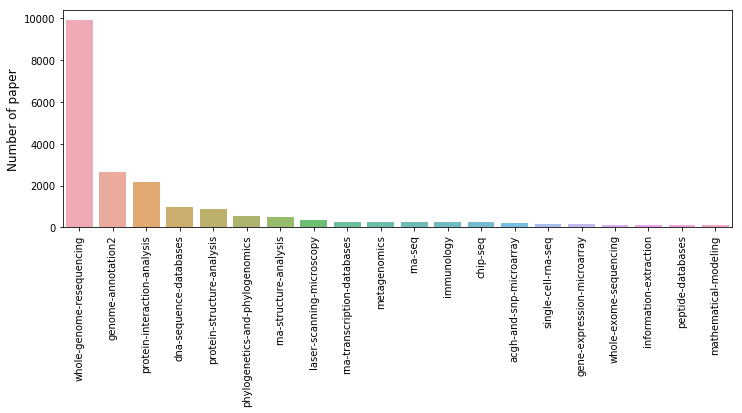

In [130]:
hist_x = []
x_label = []
for k in top_category:
    x_label.append(k[0])
    hist_x.append(k[1])

plt.figure(figsize=(12,4))
sns.barplot(x_label, hist_x, alpha=0.8)
plt.ylabel('Number of paper', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [62]:
pos_without_category = []
p_category = []
pos_ab = []
pos_title = []
abstract = {}
for p in pos_abstract_without_duplicate:
    if p[1][0] in top_category_first:
        pos_ab.append(p)
#         if p[1] == 'whole-exome-sequencing' :print(p[1])
        pos_without_category.append(p[0])
        p_category.append(p[1][0])
        if p[1][0] not in abstract: abstract[p[1][0]] = []
        abstract[p[1][0]].append(p)

In [63]:
abstract_with_title = []
abstract_with_category = {}
for c in top_category_first:
    for i in abstract[c]:
        if i[1][0] not in abstract_with_category: abstract_with_category[i[1][0]] = []
        abstract_with_category[i[1][0]].append([i[0],i[1][0]])
        abstract_with_title.append([i[0],i[1][1],i[1][2]])

In [64]:
import random

train_data = []
for c in top_category_first:
    if len(abstract_with_category[c]) > 102:
        under_indices = random.sample(range(len(abstract_with_category[c])),102)
#         print(under_indices)
        irandom = np.array(abstract_with_category[c])[under_indices]
        for i in irandom:
            train_data.append(i)
    else:
        for i in abstract_with_category[c]:
            train_data.append(i)
        
#         over_indices = np.random.choice(len(abstract[c]),2200,replace=True)
#         random = np.array(abstract[c])[over_indices]
#         for i in random:
#             train_data.append(i)

In [65]:
under_pos_without_category = []
under_p_category = []
pos_ab = []
for p in train_data:
#     print(p)
    if p[1] in top_category_first:
        pos_ab.append(p)
#         if p[1] == 'whole-exome-sequencing' :print(p[1])
        under_pos_without_category.append(p[0])
        under_p_category.append(p[1])
#         if p[1] not in abstract: abstract[p[1]] = []
#         abstract[p[1]].append(p)

In [66]:
import matplotlib.pyplot as plt

hist_abstract = {}
for i in range(len(under_pos_without_category)):
    if under_p_category[i] not in hist_abstract: hist_abstract[under_p_category[i]] = 0
    hist_abstract[under_p_category[i]] += 1

In [133]:
hist_abstract

{'whole-genome-resequencing': 102,
 'genome-annotation2': 102,
 'protein-interaction-analysis': 102,
 'dna-sequence-databases': 102,
 'protein-structure-analysis': 102,
 'phylogenetics-and-phylogenomics': 102,
 'rna-structure-analysis': 102,
 'laser-scanning-microscopy': 102,
 'rna-transcription-databases': 102,
 'metagenomics': 102,
 'rna-seq': 102,
 'immunology': 102,
 'chip-seq': 102,
 'acgh-and-snp-microarray': 102,
 'single-cell-rna-seq': 102,
 'gene-expression-microarray': 102,
 'whole-exome-sequencing': 102,
 'information-extraction': 101,
 'peptide-databases': 101,
 'mathematical-modeling': 100}

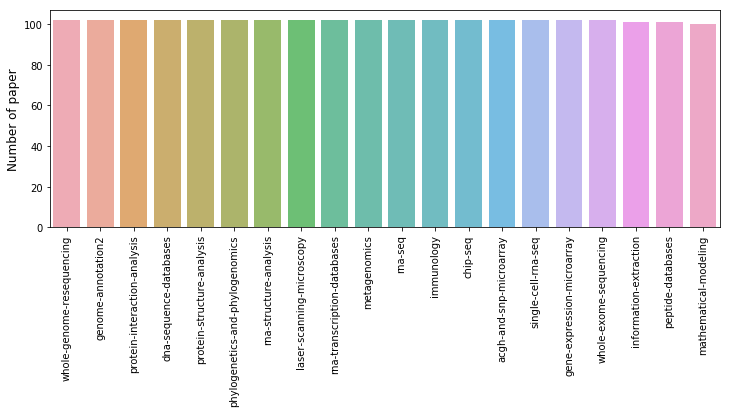

In [135]:
hist_x = []
x_label = []
for k in hist_abstract:
#     print(k)
    x_label.append(k)
    hist_x.append(hist_abstract[k])

# print(x_label)
plt.figure(figsize=(12,4))
sns.barplot(x_label, hist_x, alpha=0.8)
plt.ylabel('Number of paper', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [68]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

pos_without_category = np.array(pos_without_category)
p_category = np.array(p_category)
# X_train, X_test, y_train, y_test = train_test_split( pos_without_category, p_category, test_size=0.2, random_state=1)

X_train, X_test, y_train, y_test = train_test_split( pos_without_category, p_category, test_size=0.2, random_state=1, stratify=p_category)

ros = RandomOverSampler()
OX_train, oy_train = ros.fit_sample(X_train.reshape(-1,1), y_train)

under_pos_without_category = np.array(under_pos_without_category)
under_p_category = np.array(under_p_category)
UX_train, UX_test, uy_train, uy_test = train_test_split( under_pos_without_category, under_p_category, test_size=0.2, random_state=1,stratify=under_p_category)

In [69]:
utitle_list = []
for i in UX_train:
    for j in abstract_with_title:
        if i == j[0]:
            utitle_list.append([j[1],j[2]])

In [70]:
duplicate_list = []
for i in UX_train:
    for j in abstract_with_title:
        if i in duplicate_list:
             if i == j[0]:
                print([i,j[1],j[2]])
        else:
            if i == j[0]:
                duplicate_list.append(i)

In [71]:
from gensim.parsing.preprocessing import STOPWORDS


countvec = CountVectorizer(stop_words='english')
countvec.fit(pos_without_category)
stop = countvec.get_feature_names()
stop = [i for i in stop if i.isdigit()]
stop_words = text.ENGLISH_STOP_WORDS.union(stop)
# stop_words = STOPWORDS

In [72]:
uc_train = countvec.transform(UX_train)
uc_test = countvec.transform(UX_test)
oc_train = countvec.transform(OX_train.flatten())
oc_test = countvec.transform(X_test)

In [73]:
up_category = []
for i in under_p_category:
    up_category.append(i)

## Multinomial Naive Bayes ##

In [74]:
clf = MultinomialNB()
clf.fit(uc_train, uy_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [75]:
clf.score(uc_test,uy_test)

0.6151960784313726

In [76]:
from sklearn.metrics import f1_score
f1_score(clf.predict(uc_test),uy_test,average='macro')

0.6026604835426299

In [77]:
f1_score(clf.predict(uc_test),uy_test,average='micro')

0.6151960784313726

In [78]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

test_cat = sorted(list(set(up_category)))
cm = np.array([[0]*len(test_cat)]*len(test_cat))
predicted_result = clf.predict(uc_test)

for i in range(len(predicted_result)):
#     print(test_cat.index(predicted_result[i]),test_cat.index(y_test[i]))
    cm[test_cat.index(uy_test[i])][test_cat.index(predicted_result[i])] += 1

df_cm = pd.DataFrame(cm, index = test_cat,
                  columns = test_cat)

In [79]:
uc_test.shape

(408, 51092)

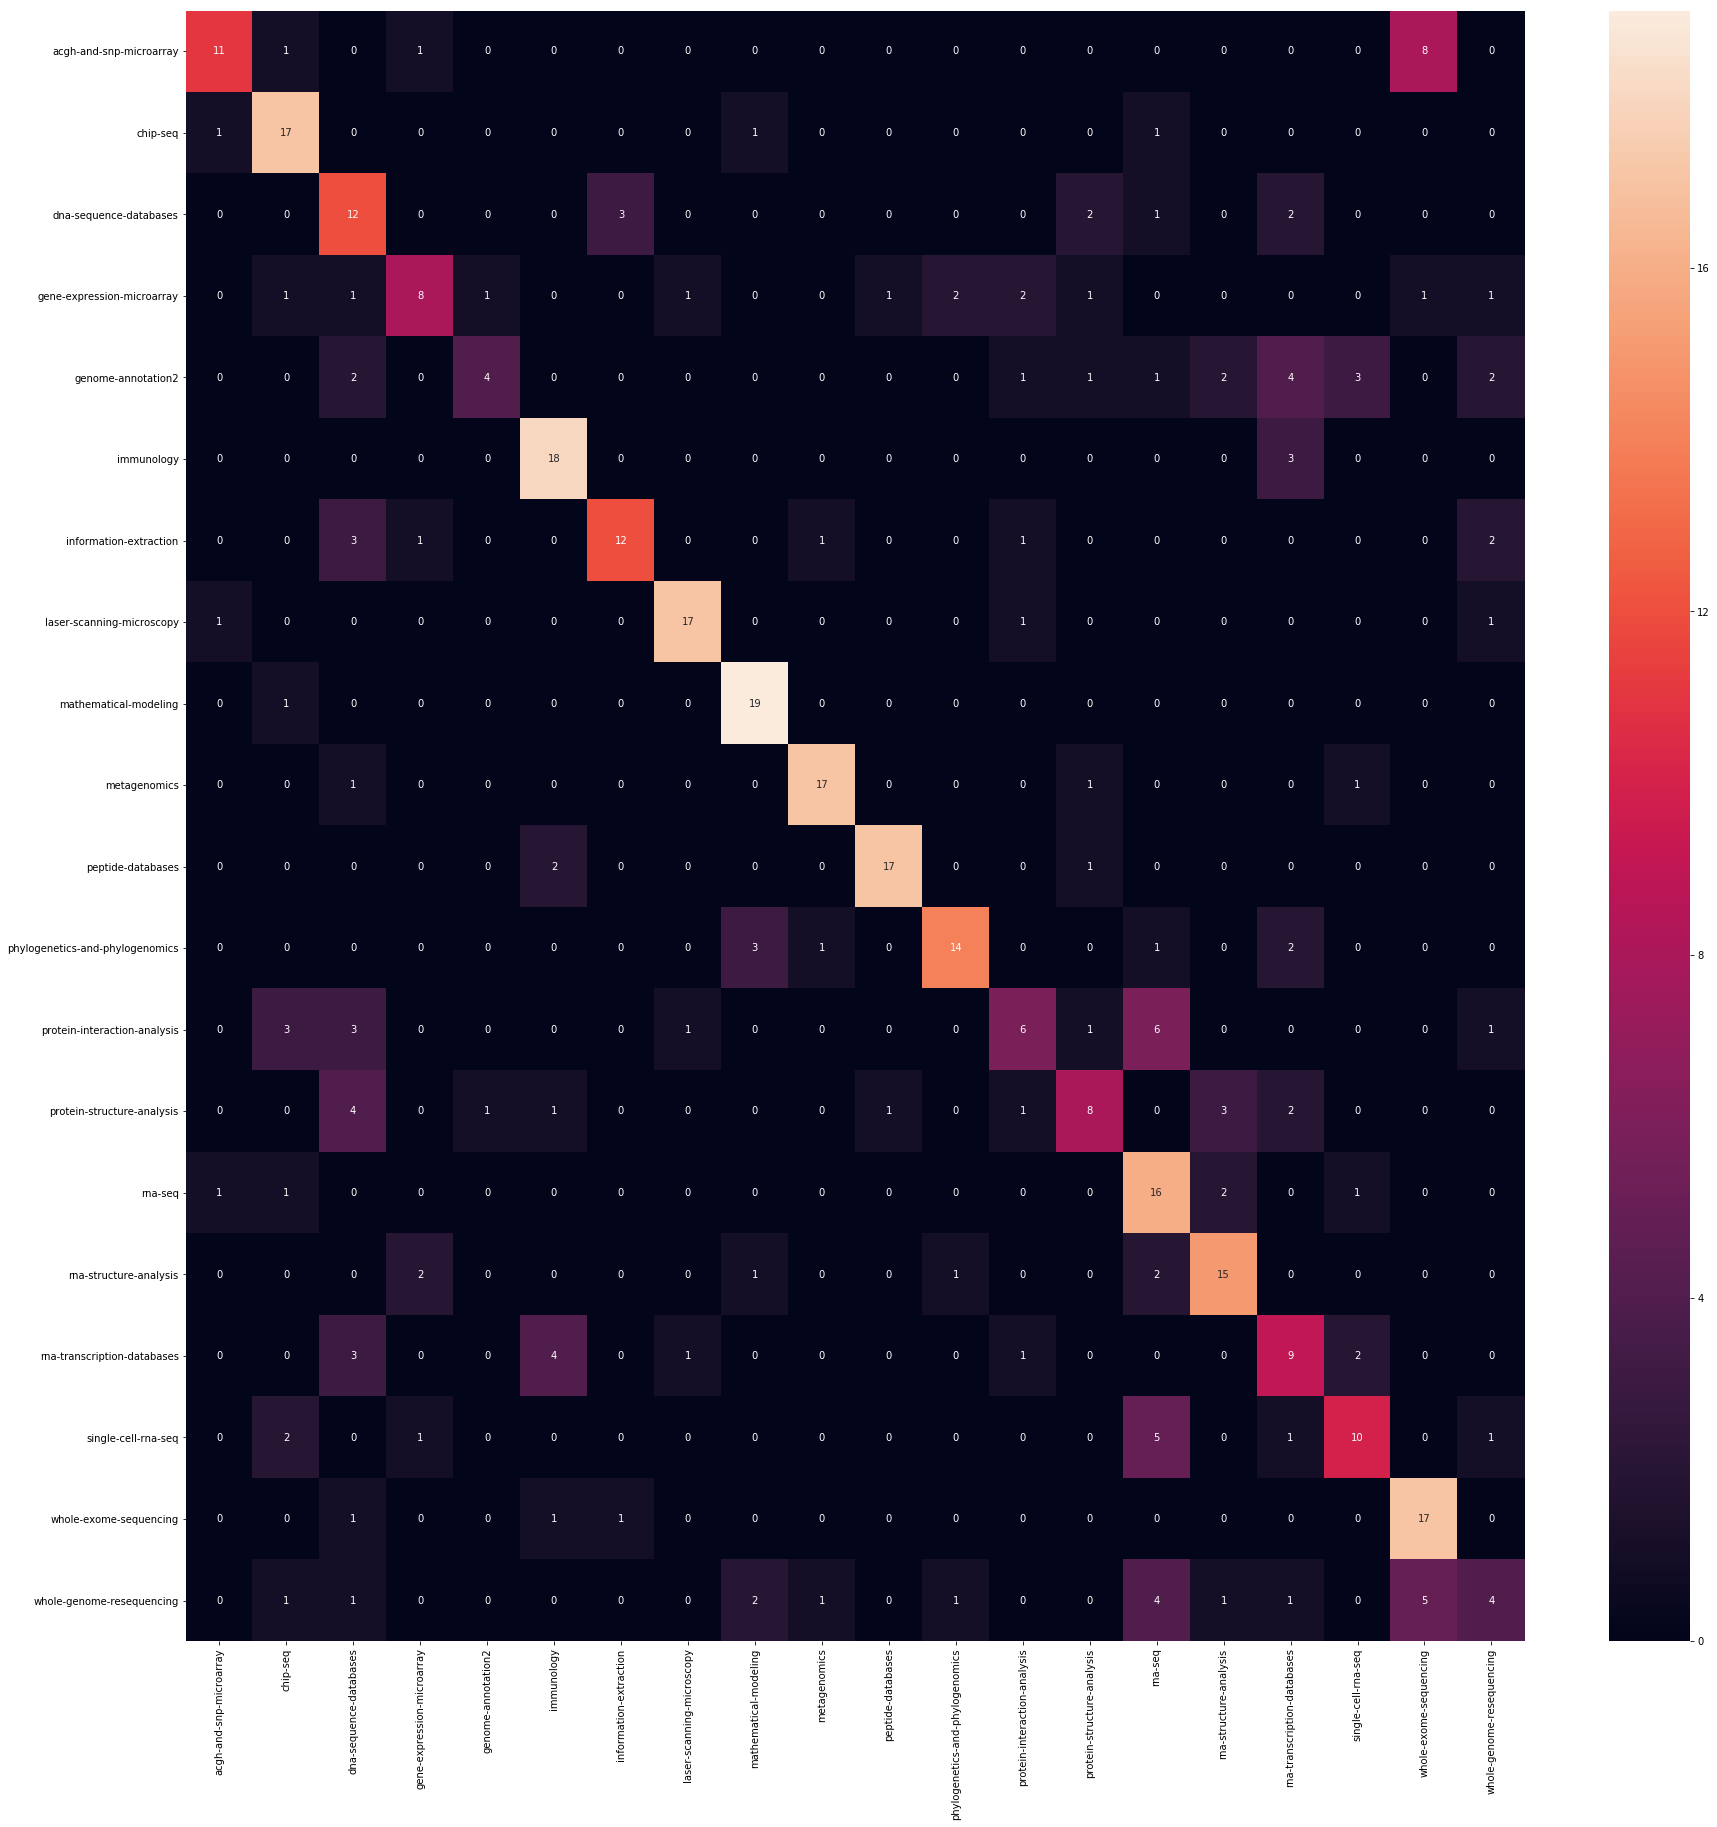

In [80]:
import seaborn as sn

plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)


In [81]:
clf = MultinomialNB()
clf.fit(oc_train, oy_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [82]:
clf.score(oc_test,y_test)

0.6464019851116626

In [83]:
test_cat = sorted(list(set(p_category)))
cm = np.array([[0]*len(test_cat)]*len(test_cat))
predicted_result = clf.predict(oc_test)

for i in range(len(predicted_result)):
#     print(test_cat.index(predicted_result[i]),test_cat.index(y_test[i]))
    cm[test_cat.index(y_test[i])][test_cat.index(predicted_result[i])] += 1

df_cm = pd.DataFrame(cm, index = test_cat,
                  columns = test_cat)

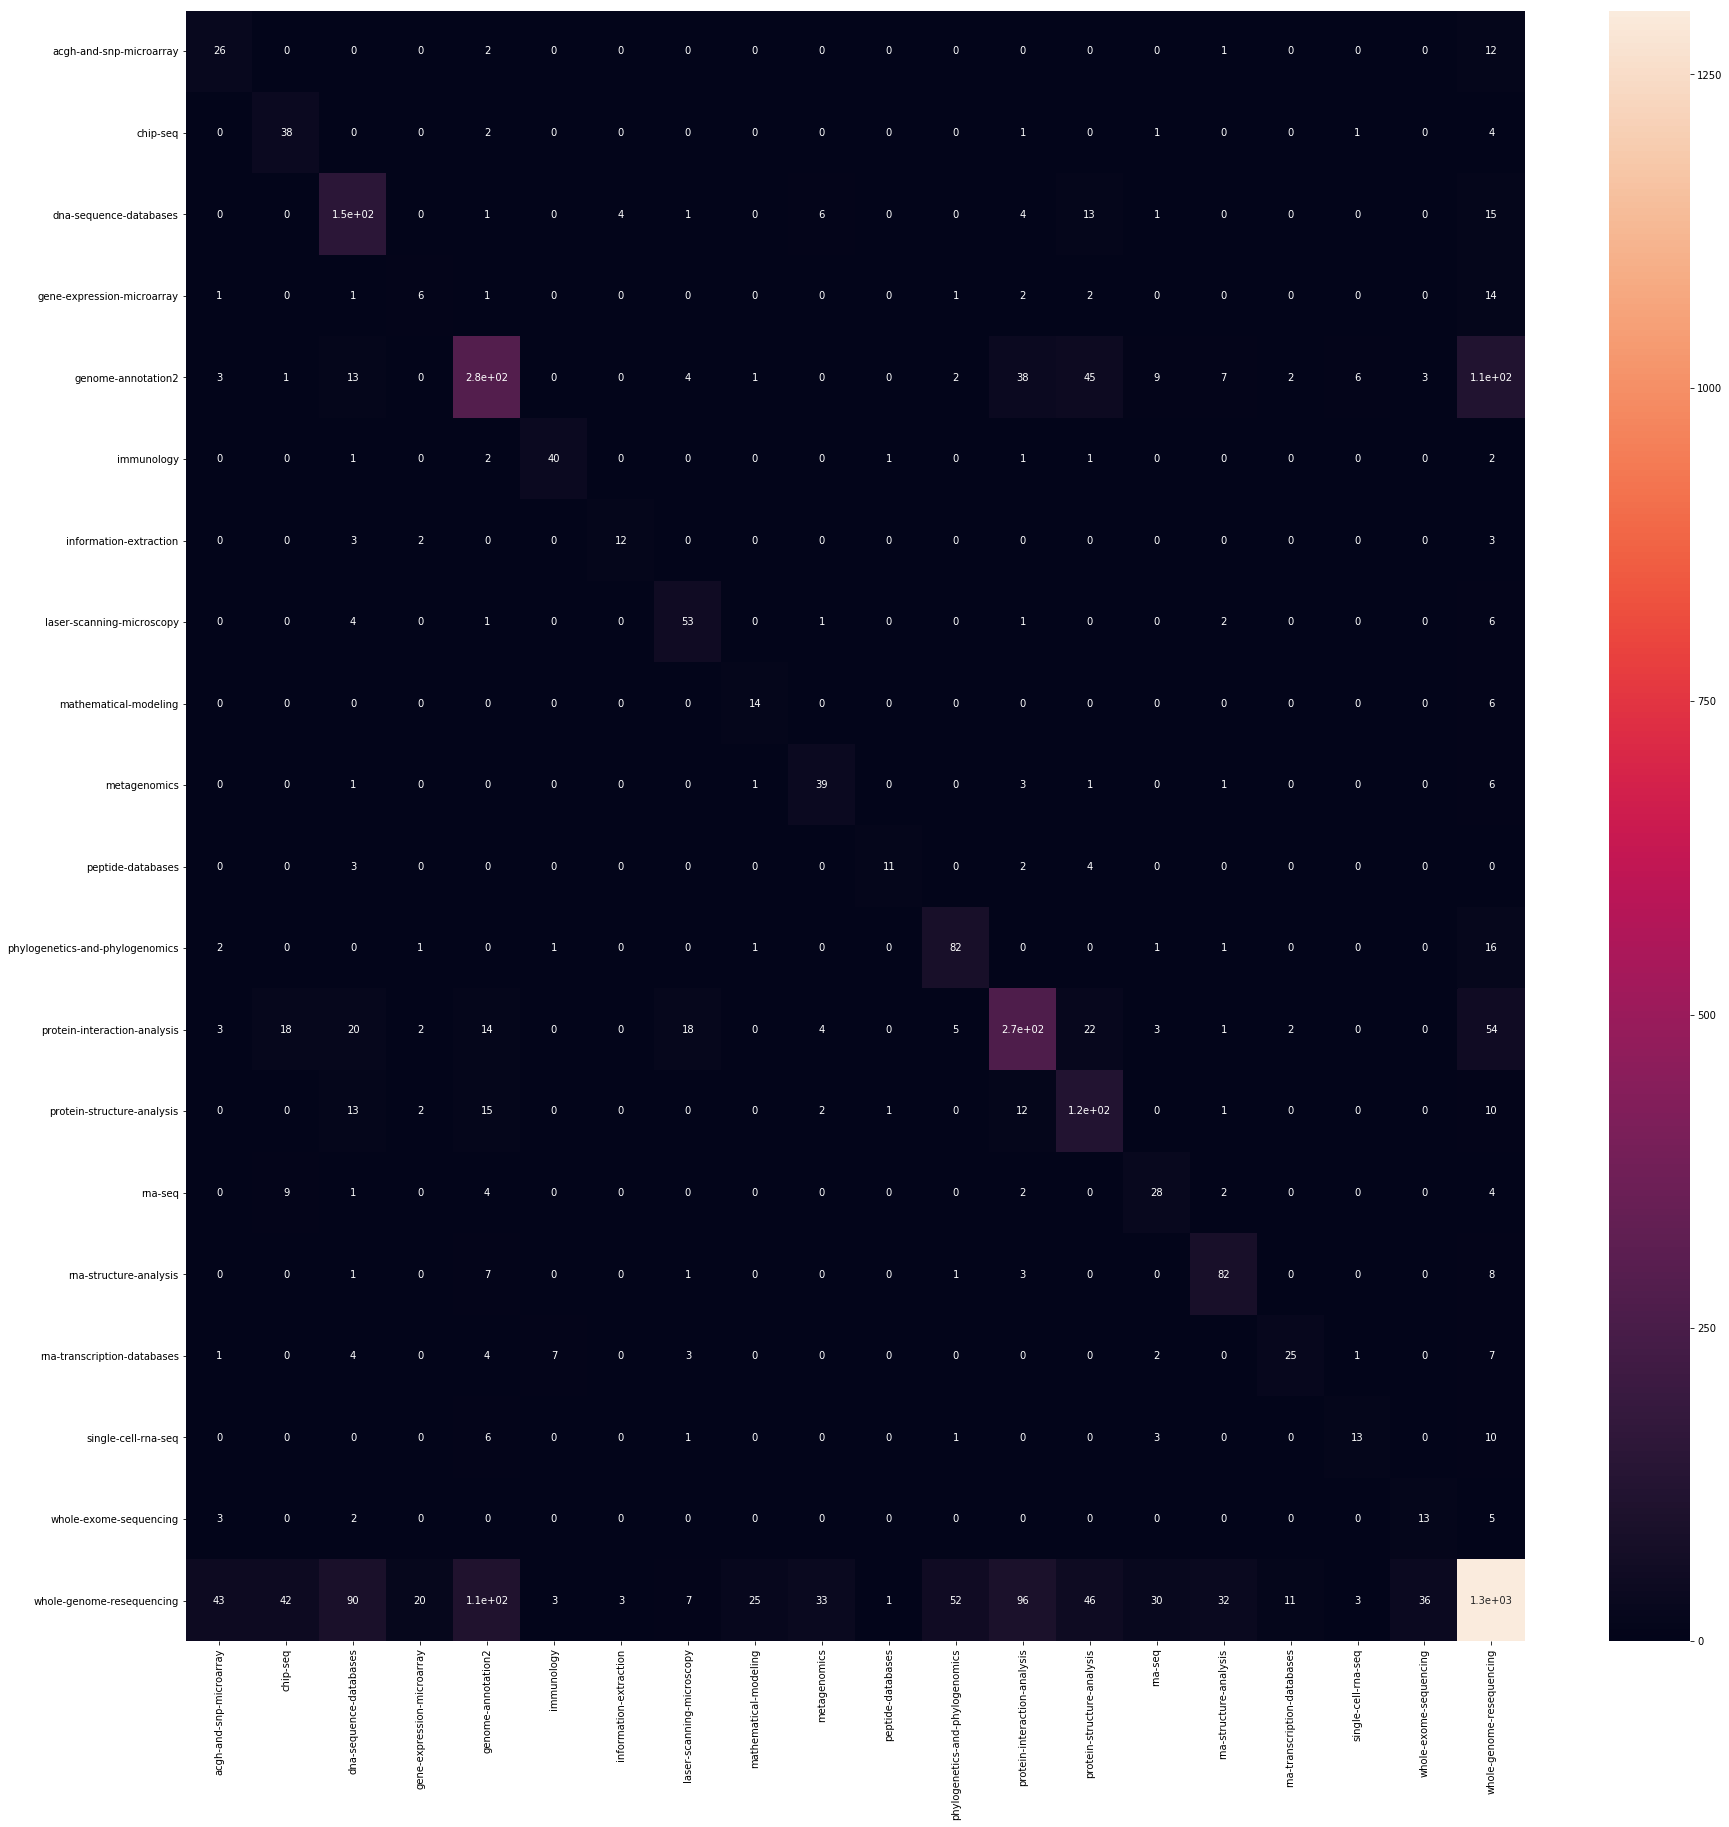

In [84]:

plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)


In [85]:
vectorizer = TfidfVectorizer(min_df=11,stop_words=set(stop_words),norm='l2')
vectorizer.fit(X_train)
tfidf_train = vectorizer.transform(UX_train)
tfidf_test = vectorizer.transform(UX_test)

In [86]:
tfidf_clf = MultinomialNB()
tfidf_clf.fit(tfidf_train, uy_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [87]:
tfidf_clf.score(tfidf_test,uy_test)

0.6274509803921569

In [88]:
f1_score(tfidf_clf.predict(tfidf_test),uy_test,average='micro')

0.6274509803921569

In [89]:
f1_score(tfidf_clf.predict(tfidf_test),uy_test,average='macro')

0.6044812846214589

In [90]:
test_cat = sorted(list(set(p_category)))
tfidf_cm = np.array([[0]*len(test_cat)]*len(test_cat))
predicted_result = tfidf_clf.predict(tfidf_test)

for i in range(len(predicted_result)):
#     print(test_cat.index(predicted_result[i]),test_cat.index(y_test[i]))
    tfidf_cm[test_cat.index(uy_test[i])][test_cat.index(predicted_result[i])] += 1

tfidf_df_cm = pd.DataFrame(tfidf_cm, index = test_cat,
                  columns = test_cat)

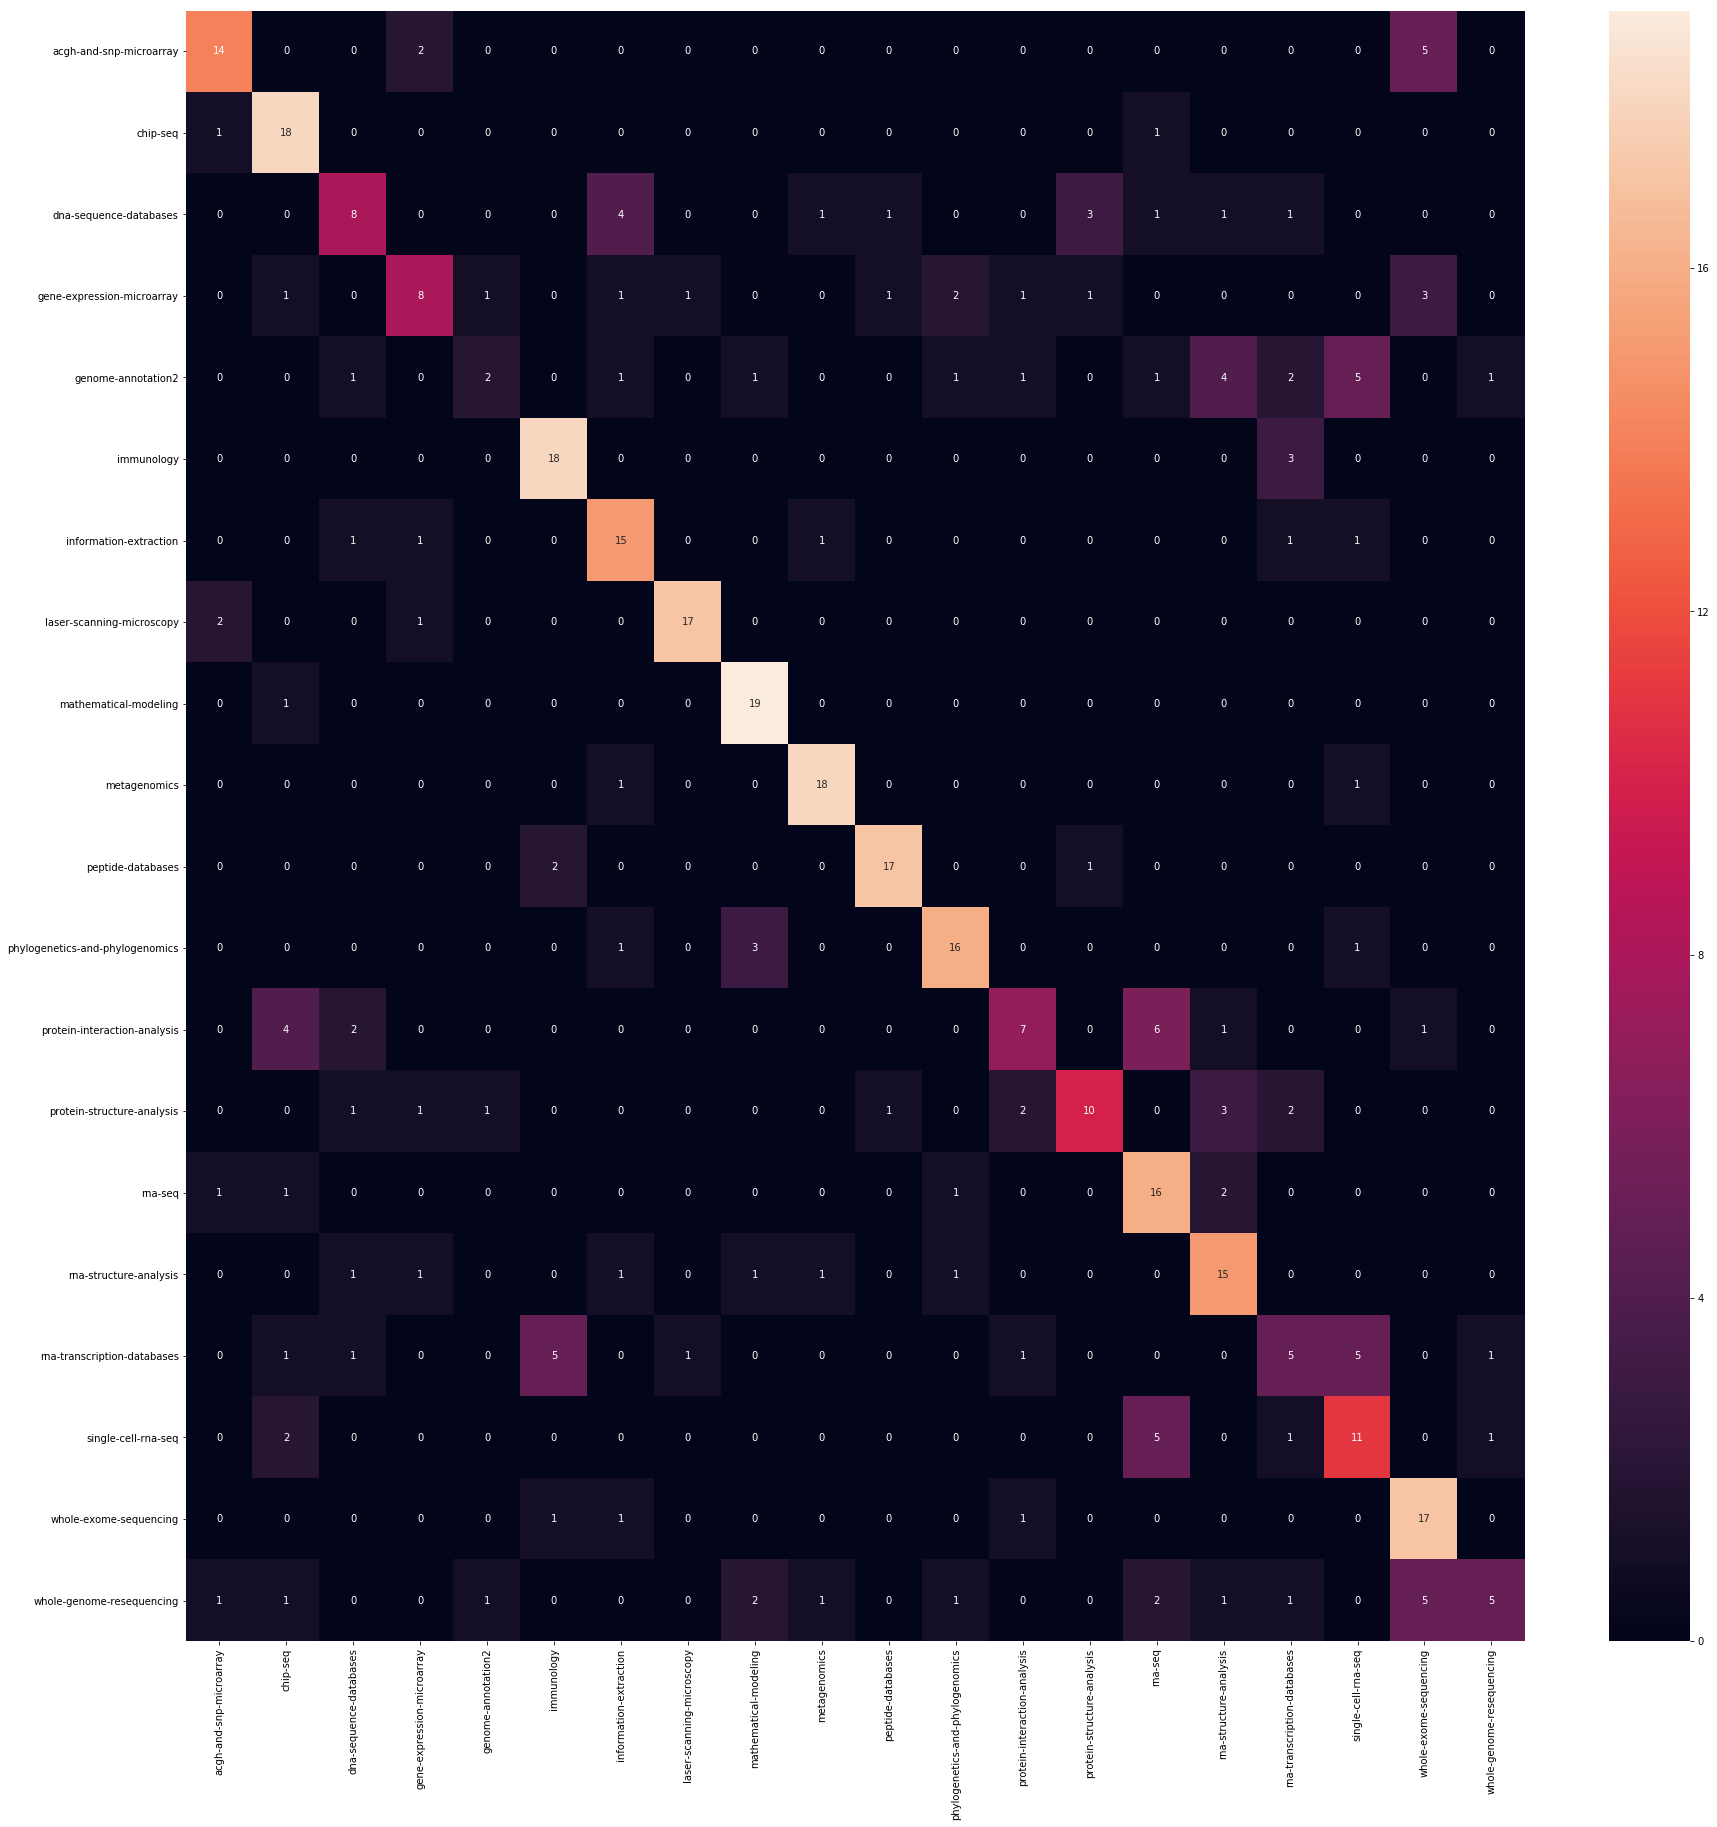

In [91]:
plt.figure(figsize = (30,30))
sn.heatmap(tfidf_df_cm, annot=True)


In [92]:
y_dict = {}
for y in y_test:
    if y not in y_dict:y_dict[y] = 0
    y_dict[y] +=1

In [93]:
y_dict

{'genome-annotation2': 528,
 'laser-scanning-microscopy': 68,
 'whole-genome-resequencing': 1982,
 'protein-interaction-analysis': 435,
 'phylogenetics-and-phylogenomics': 105,
 'dna-sequence-databases': 196,
 'immunology': 48,
 'metagenomics': 52,
 'protein-structure-analysis': 176,
 'peptide-databases': 20,
 'rna-structure-analysis': 103,
 'whole-exome-sequencing': 23,
 'acgh-and-snp-microarray': 41,
 'information-extraction': 20,
 'single-cell-rna-seq': 34,
 'chip-seq': 47,
 'gene-expression-microarray': 28,
 'rna-seq': 50,
 'rna-transcription-databases': 54,
 'mathematical-modeling': 20}

## Linear SVC ##

In [94]:
svc = LinearSVC(C=1.0,random_state=0,tol=10e-1)
svc.fit(tfidf_train, uy_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0)

In [95]:
svc.score(tfidf_test,uy_test)

0.6715686274509803

In [96]:
test_cat = sorted(list(set(p_category)))
svc_cm = np.array([[0]*len(test_cat)]*len(test_cat))
predicted_result = svc.predict(tfidf_test)

for i in range(len(predicted_result)):
#     print(test_cat.index(predicted_result[i]),test_cat.index(y_test[i]))
    svc_cm[test_cat.index(uy_test[i])][test_cat.index(predicted_result[i])] += 1

svc_df_cm = pd.DataFrame(svc_cm, index = test_cat,
                  columns = test_cat)

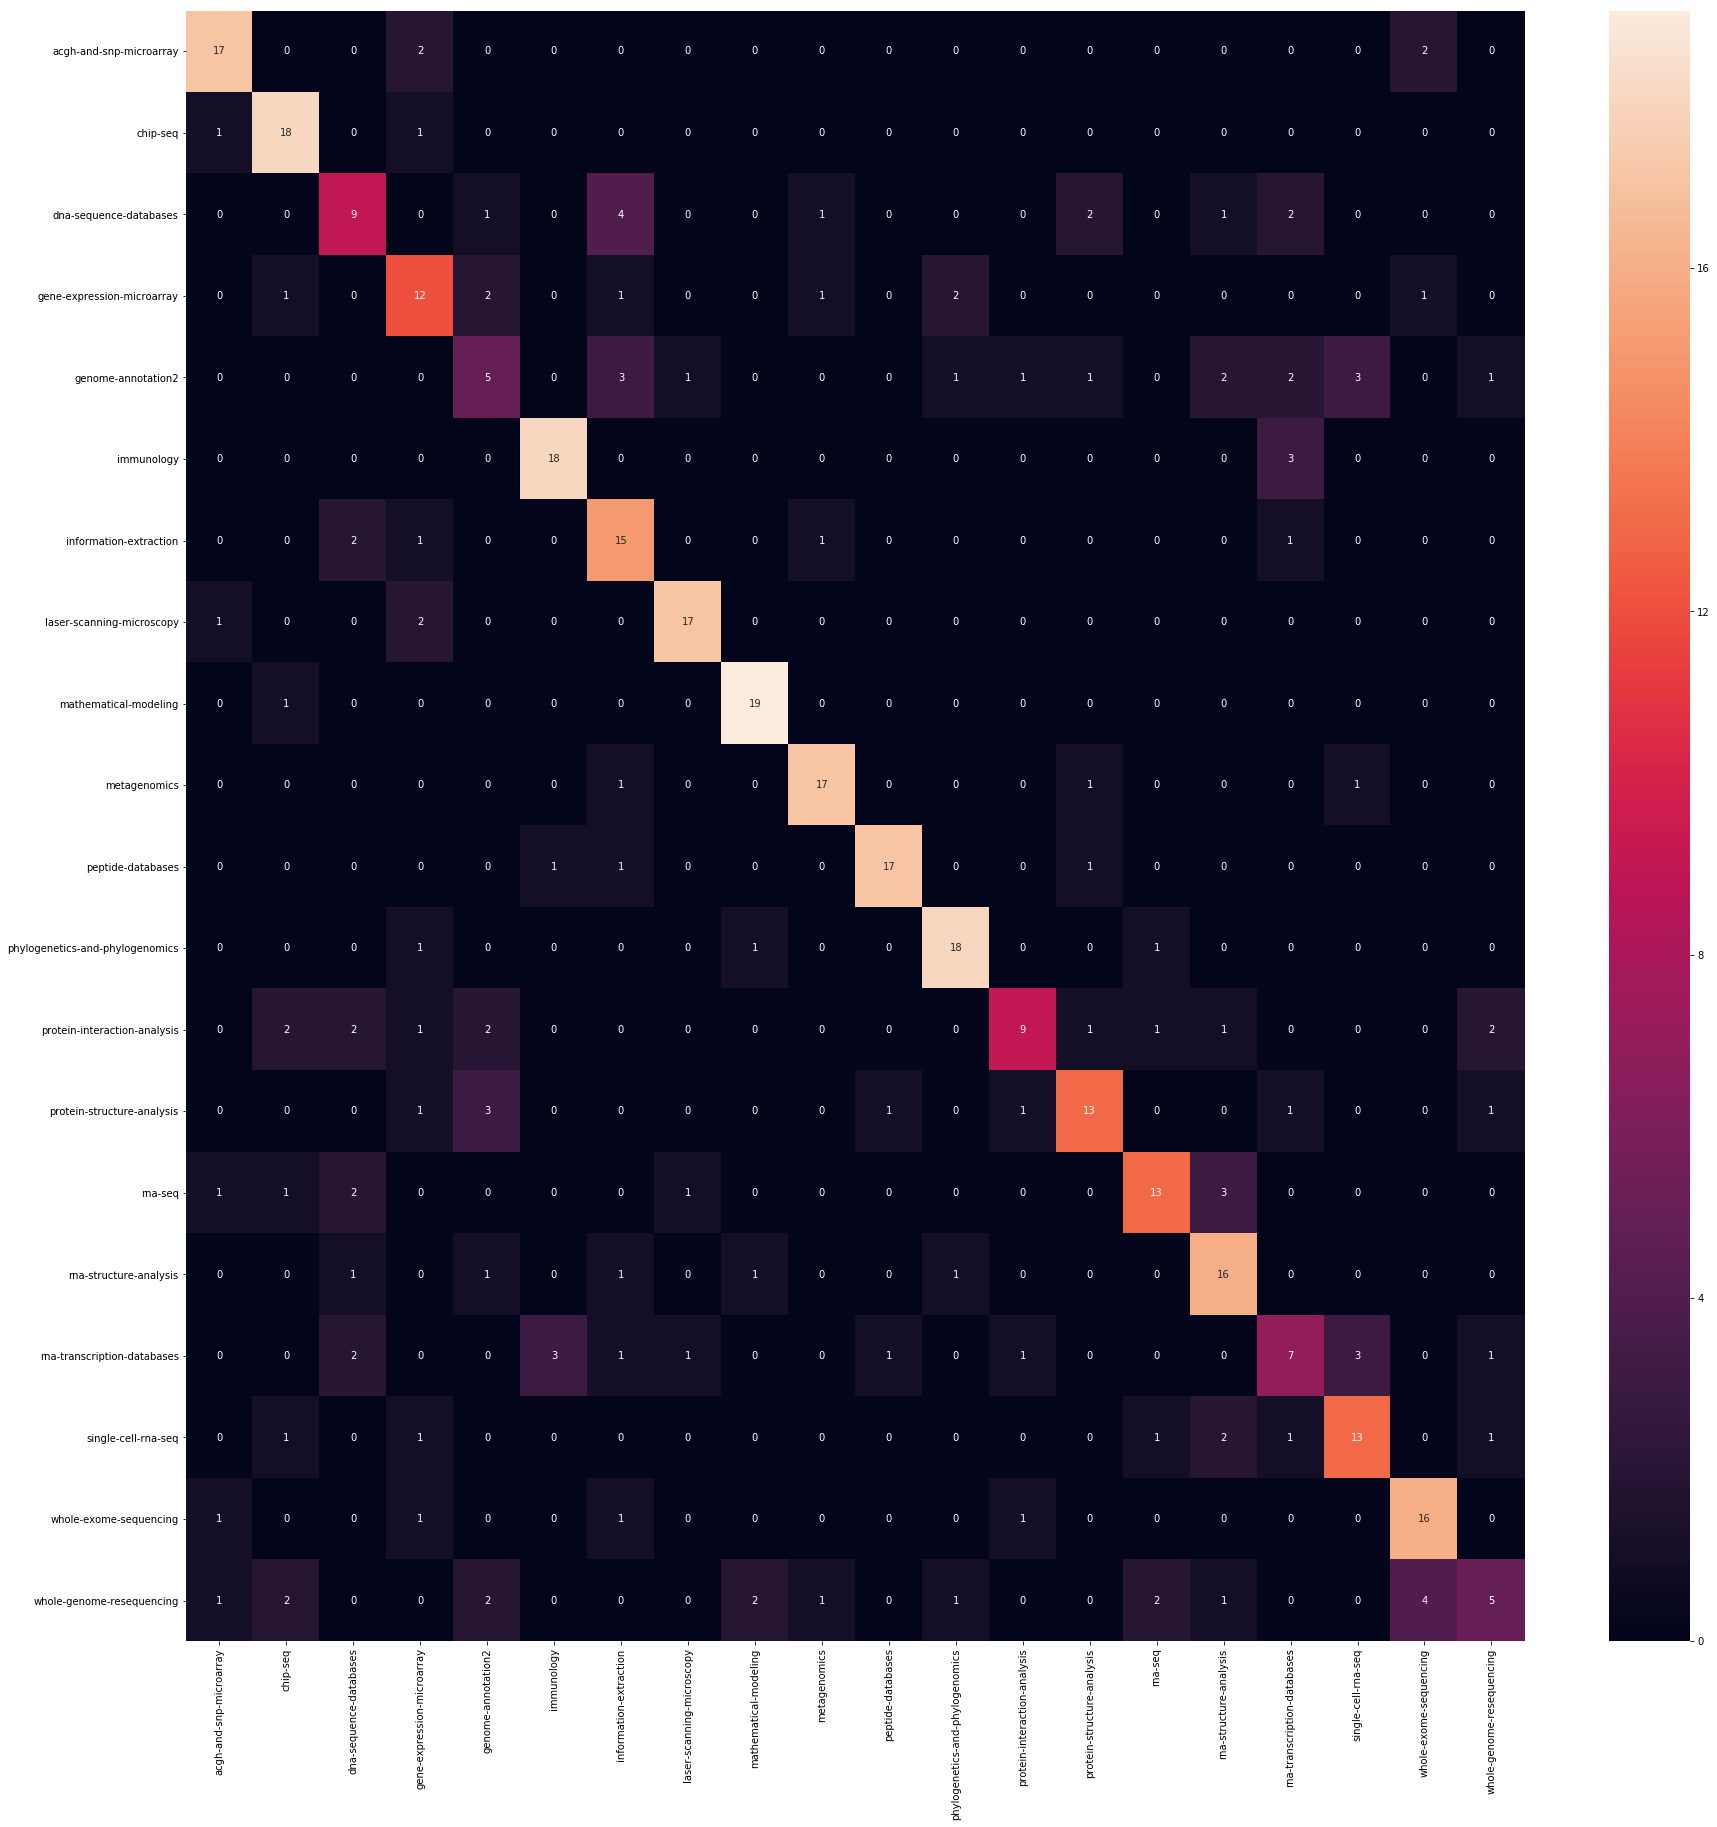

In [97]:
plt.figure(figsize = (30,30))
sn.heatmap(svc_df_cm, annot=True)


In [98]:
tfidf_features = vectorizer.get_feature_names()

In [99]:
key_list = []
for t in tfidf_test.toarray():
    keyword =[]
    for i in range(len(t)):
        if t[i] > 0.15:
            keyword.append(tfidf_features[i])
    key_list.append(keyword)

In [100]:
predicted_result = tfidf_clf.predict_proba(tfidf_test)

In [101]:
predict_class = []
for predict in predicted_result:
    c = []
#     sort_predict = sorted(predict)
#     print(sort_predict)
    for i in range(len(predict)):
        if predict[i] > 0.05:
            c.append(tfidf_clf.classes_[i])
    predict_class.append(c)

In [102]:
count = 0
for c in predict_class:
    if len(c) == 0:
        count += 1
print(count)

0


In [103]:
tool_matrix = []
for i in range(len(uy_test)):
    tool_matrix.append([utitle_list[i],key_list[i],uy_test[i],predict_class[i]])

In [104]:
count = 0
for i in range(len(uy_test)):
    if uy_test[i] in predict_class[i]:
        count += 1
print(count/len(uy_test))

0.9779411764705882


In [105]:
tool_df = pd.DataFrame(tool_matrix, index = np.arange(1,len(tool_matrix)+1),
                  columns = ["Title","Keywords","Actual category","Predicted_Categories"])

In [106]:
tool_df.to_csv("Bioinformatic_Tool_Predict.csv")


## Doc2Vec ##

In [107]:
from sklearn import utils
from gensim.models.doc2vec import LabeledSentence,TaggedDocument
from gensim.models import Doc2Vec

from tqdm import tqdm
import multiprocessing
cores = multiprocessing.cpu_count()


In [108]:
under_token_with_category = []

for i in range(0,len(under_pos_without_category)):   
    print(str(((i+1)/len(under_pos_without_category))*100),end="\r")
    under_token_with_category.append(TaggedDocument(words=simple_preprocess(under_pos_without_category[i]),tags=under_p_category[i]))


In [109]:
TX_train,TX_test,ty_train,ty_test = train_test_split(under_token_with_category,under_p_category)

In [110]:
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores)

model_dbow.build_vocab(TX_train)


In [111]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(TX_train)]), total_examples=len(TX_train), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|█████████████████████████████████████████████████████████████████████████| 1527/1527 [00:00<00:00, 1529663.77it/s]


Wall time: 57.3 s


In [112]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
           
    targets, regressors = zip(*[[doc.tags, model.infer_vector(doc.words, steps=20)] for doc in sents])
    return targets, regressors

In [113]:
dy_train, DX_train = vec_for_learning(model_dbow, TX_train)
dy_test, DX_test = vec_for_learning(model_dbow, TX_test)


In [114]:
t = [0]*20
t[0] += 1

In [115]:
one_hot_dy_train = []
for i in dy_train:
    t = [0]*20
    t[top_category_first.index(dy_train[0])] += 1
    one_hot_dy_train.append(t)

In [116]:
one_hot_dy_test = []
for i in dy_test:
    t = [0]*20
    t[top_category_first.index(dy_test[0])] += 1
    one_hot_dy_test.append(t)

In [117]:
import google.protobuf

In [118]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten


Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "c:\users\waii\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "c:\users\waii\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "c:\users\waii\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "c:\users\waii\appdata\local\programs\python\python36\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "c:\users\waii\appdata\local\programs\python\python36\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
def createCNNmodel():
    model = Sequential()
    model.add(Conv2D(256,(5,5),activation='relu'))
    model.add(Conv2D(256,(5,5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256,(5,5),activation='relu'))
    model.add(Conv2D(256,(5,5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu'))
    
    return model

In [ ]:
model = createCNNmodel()
batch_size = 256
epochs = 100

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(DX_train, dy_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(DX_test, dy_test))
 